# MNIST with Pytorch

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

In [4]:
import torch
from torch.utils.data.dataset import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [5]:
TRAIN_DATA = '/tmp/train.csv'

In [4]:
tmp = pd.read_csv(TRAIN_DATA, nrows=5)
tmp = tmp.loc[:, tmp.columns != 'label']
tmp

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data loading

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

* `__len__` so that `len(dataset)` returns the size of the dataset.
* `__getitem__` to support the indexing such that `dataset[i]` can be used to get ith sample

The data must be wrapped in a Dataset class. First the data must be wrapped in a Dataset class with a `getitem` method that from an index return `X_train[index]` and `y_train[index]` and a length method. A Dataset is basically a data storage. We will read the csv in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are not stored in the memory at once but read as required.

In [6]:
class MNISTDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        df = pd.read_csv(csv_file).astype(np.float32)
        self.enc = OneHotEncoder()
        self.X_train = df.loc[:, df.columns != 'label'].as_matrix()
        self.y_train = self.enc.fit_transform(df['label'].values.reshape(-1, 1)).toarray()
        self.transform = transform

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        data = torch.from_numpy(self.X_train[index])
        label = torch.Tensor(self.y_train[index])
        
        if self.transform:
            data = self.transform(data)

        return data, label

In [38]:
dset_train = MNISTDataset(csv_file = TRAIN_DATA)

tensor([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])


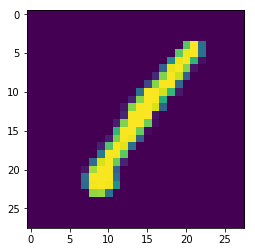

In [8]:
print(dset_train[0][1])
plt.imshow(dset_train[0][0].view(28, 28).numpy())

In [39]:
dset_loader = DataLoader(dset_train, batch_size=256, shuffle=True)

## Multilayer Perceptron

In [47]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [48]:
mlp = MLP()
#criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCELoss()
#criterion = F.binary_cross_entropy
optimizer = optim.SGD(mlp.parameters(), lr=0.001)
                      
for epoch in range(2):  # loop over the dataset multiple times
    mlp.train()
    for batch_idx, (data, target) in enumerate(dset_loader):
        # get the inputs
        data, target = Variable(data), Variable(target)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = mlp(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(dset_loader.dataset),
                100. * batch_idx / len(dset_loader), 
                loss.data.item()
            ))

Train Epoch: 0 [0/42000 (0%)]	Loss: 7.380072
Train Epoch: 0 [2560/42000 (6%)]	Loss: 1.451335
Train Epoch: 0 [5120/42000 (12%)]	Loss: 1.133739
Train Epoch: 0 [7680/42000 (18%)]	Loss: 0.664101
Train Epoch: 0 [10240/42000 (24%)]	Loss: 0.664842
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.665082
Train Epoch: 0 [15360/42000 (36%)]	Loss: 0.530678
Train Epoch: 0 [17920/42000 (42%)]	Loss: 0.507366
Train Epoch: 0 [20480/42000 (48%)]	Loss: 0.365820
Train Epoch: 0 [23040/42000 (55%)]	Loss: 0.396803
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.317529
Train Epoch: 0 [28160/42000 (67%)]	Loss: 0.367664
Train Epoch: 0 [30720/42000 (73%)]	Loss: 0.280107
Train Epoch: 0 [33280/42000 (79%)]	Loss: 0.370477
Train Epoch: 0 [35840/42000 (85%)]	Loss: 0.245904
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.301574
Train Epoch: 0 [40960/42000 (97%)]	Loss: 0.229639
Train Epoch: 1 [0/42000 (0%)]	Loss: 0.282863
Train Epoch: 1 [2560/42000 (6%)]	Loss: 0.283320
Train Epoch: 1 [5120/42000 (12%)]	Loss: 0.301545
Train Epoch: 1 [7

In [15]:
print(dset_train[0][1])
mlp(dset_train[0][0])

tensor([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])


tensor([ 1.0724e-09,  9.9995e-01,  2.8310e-02,  5.1610e-07,  4.9424e-07,
         6.8401e-08,  2.6044e-09,  5.2415e-03,  6.1218e-02,  9.1099e-06])

## ConvNet

In [85]:
dset_train = MNISTDataset(csv_file = TRAIN_DATA, transform = (lambda x: x.view(1, 28, 28)))
dset_loader = DataLoader(dset_train, batch_size=256, shuffle=True)

In [88]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [89]:
conv_net = ConvNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(conv_net.parameters(), lr=0.001)

for epoch in range(2):  # loop over the dataset multiple times
    conv_net.train()
    for batch_idx, (data, target) in enumerate(dset_loader):
        # get the inputs
        data, target = Variable(data), Variable(target)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = conv_net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(dset_loader.dataset),
                100. * batch_idx / len(dset_loader), 
                loss.data.item()
            ))

Train Epoch: 0 [0/42000 (0%)]	Loss: 6.050994
Train Epoch: 0 [2560/42000 (6%)]	Loss: 0.484892
Train Epoch: 0 [5120/42000 (12%)]	Loss: 0.275754
Train Epoch: 0 [7680/42000 (18%)]	Loss: 0.229722
Train Epoch: 0 [10240/42000 (24%)]	Loss: 0.186822
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.145604
Train Epoch: 0 [15360/42000 (36%)]	Loss: 0.123394
Train Epoch: 0 [17920/42000 (42%)]	Loss: 0.111459
Train Epoch: 0 [20480/42000 (48%)]	Loss: 0.085979
Train Epoch: 0 [23040/42000 (55%)]	Loss: 0.099859
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.061109
Train Epoch: 0 [28160/42000 (67%)]	Loss: 0.067298
Train Epoch: 0 [30720/42000 (73%)]	Loss: 0.063181
Train Epoch: 0 [33280/42000 (79%)]	Loss: 0.063011
Train Epoch: 0 [35840/42000 (85%)]	Loss: 0.048802
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.052184
Train Epoch: 0 [40960/42000 (97%)]	Loss: 0.052897
Train Epoch: 1 [0/42000 (0%)]	Loss: 0.069507
Train Epoch: 1 [2560/42000 (6%)]	Loss: 0.049335
Train Epoch: 1 [5120/42000 (12%)]	Loss: 0.040764
Train Epoch: 1 [7